# Company Categorizing and Extraction / Data Cleaning

In [15]:
import csv
import numpy as np
import pandas as pd
import math
from pathlib import Path

dataset = 'filtered_vcInsight.csv'
filepath = Path('commerce_comp_dirty.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
filepath2 = Path('commerce_comp_clean.csv')  
filepath2.parent.mkdir(parents=True, exist_ok=True) 

# should scale for future data extraction
commerce_companies = []
commerce_cat = ['Internet & Direct Marketing Retail']
companies_df = pd.read_csv(dataset)
logical = companies_df.industry.isin(commerce_cat).tolist()
commerce_companies_df = companies_df[logical]
commerce_companies_np = commerce_companies_df.to_numpy()
commerce_companies_df.to_csv(filepath)
p = 0

# clean the data
commerce_companies_df = pd.read_csv(filepath)

# remove percentage signs from the data
commerce_companies_df['revenue_growth'] = commerce_companies_df['revenue_growth'].str.replace('%', '')
commerce_companies_df['employee_growth_6'] = commerce_companies_df['employee_growth_6'].str.replace('%', '')
commerce_companies_df['employee_growth_12'] = commerce_companies_df['employee_growth_12'].str.replace('%', '')

column_head = ['name_c',
             'incorporated_date_c',
             'total_funding_c',
             'last_valuation_c',
             'last_round_size_c',
             'revenue_c',
             'date_of_last_round',
             'fy_end',
             'revenue_growth',
             'EBIT_c',
             'employee_growth_6',
             'employee_growth_12',
             'num_founders',
             'num_funding_rounds',
             'num_shareholders',
             'min_share',
             'median_share',
             'max_share',
             'category',
             'industry'
]

# change dashed values or nan values to -1 (so that model has something to train with: further research on how to handle non-existent values)
for i,col_head in enumerate(column_head):
    commerce_companies_df[col_head] = commerce_companies_df[col_head].fillna(-1)
for i,col_head in enumerate(column_head):
    commerce_companies_df[col_head] = commerce_companies_df[col_head].replace(to_replace='-',value='-1')

type_dict = {'name_c':'str', #0
             'incorporated_date_c':'int',#1
             'total_funding_c':'float',#2
             'last_valuation_c':'float',#3
             'last_round_size_c':'float',#4
             'revenue_c':'float',#5
             'date_of_last_round':'str',#6
             'fy_end':'str',#7
             'revenue_growth':'float',#8
             'EBIT_c':'float',#9
             'employee_growth_6':'float',#10
             'employee_growth_12':'float',#11
             'num_founders':'float',#12
             'num_funding_rounds':'float',#13
             'num_shareholders':'float',#14
             'min_share':'float',#15
             'median_share':'float',#16
             'max_share':'float',#17
             'category':'str',#18
             'industry':'str'#20
}
commerce_companies_df = commerce_companies_df.astype(type_dict)

# convert percentage to fractions
commerce_companies_df['revenue_growth'] = commerce_companies_df['revenue_growth']/100
commerce_companies_df['employee_growth_6'] = commerce_companies_df['employee_growth_6']/100
commerce_companies_df['employee_growth_12'] = commerce_companies_df['employee_growth_12']/100
commerce_companies_df.to_csv(filepath2) 
clean_commerce_companies_data = commerce_companies_df.to_numpy()

list_of_features = [0,1,2,9,10,11,13,14,5,8,15,16,17]

## input
# 'name_c':'str', #0
# 'incorporated_date_c':'int',#1
# 'total_funding_c':'float',#2
# 'EBIT_c':'float',#9
# 'employee_growth_6':'float',#10
# 'employee_growth_12':'float',#11
# 'num_funding_rounds':'float',#13
# 'num_shareholders':'float',#14

# # output
# 'revenue_growth':'float',#8
# 'min_share':'float',#15
# 'median_share':'float',#16
# 'max_share':'float',#17

# Training Model 

In [16]:
import xgboost as xgb
from sklearn.metrics import explained_variance_score
import GPy.util.normalizer as normal
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path 
from sklearn.model_selection import train_test_split
import pickle

def load_data_xgboost():
    filepath = Path('commerce_comp_clean.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    commerce_comp_df = pd.read_csv(filepath)
    input_param = commerce_comp_df[['total_funding_c', 'EBIT_c', 'employee_growth_6', 'employee_growth_12', 'num_funding_rounds', 'num_shareholders','revenue_c']]
    output_param = commerce_comp_df[['revenue_growth', 'min_share', 'median_share', 'max_share']]
    input_features = input_param.values
    output_features = output_param.values
    input_train, input_test, output_train, output_test = train_test_split(input_features, output_features, test_size=0.1,shuffle=True)
    return input_train, input_test, output_train, output_test

xgb.__version__

'1.7.5'

In [17]:
# stats for train
input_train, input_test, output_train, output_test = load_data_xgboost()
number_of_targets = 4

# # for multi target
output_train = output_train[:,:number_of_targets]
output_test = output_test[:,:number_of_targets]

# Output: # [['revenue_growh', 'min_share', 'median_share', 'max_share']]
training_mean_in = np.mean(input_train,axis=0)
training_std_in = np.std(input_train,axis=0)
training_mean_out = np.mean(output_train,axis=0)
training_std_out = np.std(output_train,axis=0)

In [18]:
# Instantiate the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=2500, shuffle=True,num_boost_round = 100000000,eta = 0.01, max_depth= 1000,
 min_child_weight= 6)

# Train the model on the training set
xg_reg.fit(input_train, output_train)



[05:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round", "shuffle" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=1000,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, n_estimators=2500, n_jobs=None,
             num_boost_round=100000000, num_parallel_tree=None, ...)

# Validation, Performance Evaluation and Save Model

RMSE (revenue_growth): 4.069465338408847
RMSE (min_share): 15.741724883040547
RMSE (median_share): 6.944946197255052
RMSE (max_share): 20.18760338028511


Company 0
Revenue Growth (Latest Financial Year): GT: 0.14000, Pred: -0.04143, % Error: 129.59
Min Share: GT: 100.00000, Pred: 99.67106, % Error: 0.33
Median Share: GT: 100.00000, Pred: 98.33450, % Error: 1.67
Max Share: GT: 100.00000, Pred: 101.81909, % Error: 1.82


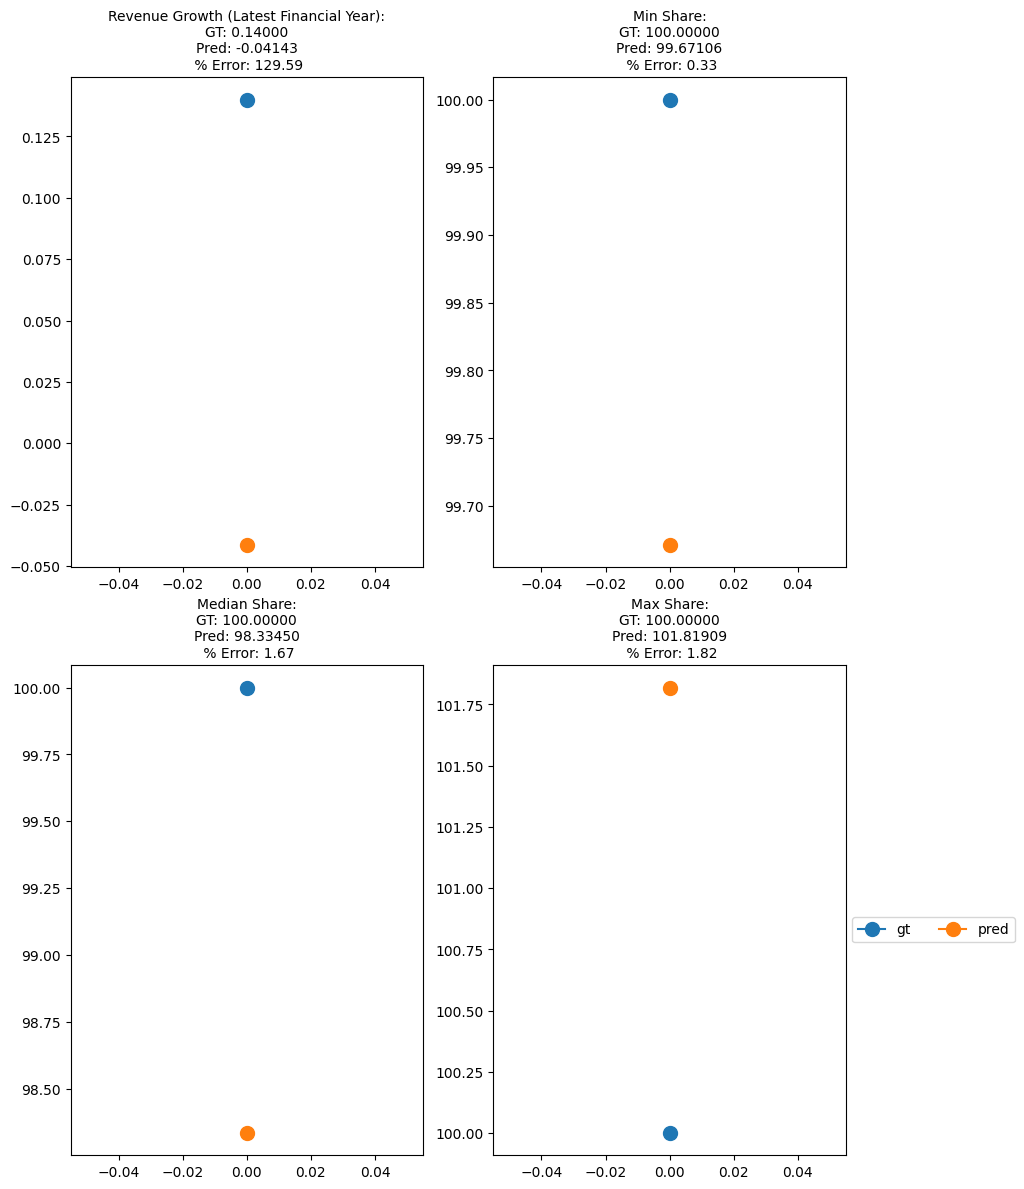



Finished Training and Inferencing. Saving Model


In [36]:
# Make predictions on the testing set
y_pred = xg_reg.predict(input_test)
# Calculate the mean squared error for each output of all test companies
mse_arr = []
rmse_rev_grwth = mean_squared_error(output_test[:, 0], y_pred[:,0])
rmse_min_shr = mean_squared_error(output_test[:, 1], y_pred[:, 1])
rmse_med_shr = mean_squared_error(output_test[:, 2], y_pred[:, 2])
rmse_max_shr = mean_squared_error(output_test[:, 3], y_pred[:, 3])
print('RMSE (revenue_growth):', np.sqrt(rmse_rev_grwth))
print('RMSE (min_share):', np.sqrt(rmse_min_shr))
print('RMSE (median_share):', np.sqrt(rmse_med_shr))
print('RMSE (max_share):', np.sqrt(rmse_max_shr))
print("\n")

# visualize the data for each separate company in the batched company
error_sum = np.zeros(number_of_targets)
for j,current_company in enumerate(output_test):
    gt = current_company
    pred = y_pred[j]
    metrics = ['Revenue Growth (Latest Financial Year)','Min Share','Median Share','Max Share']

    print(f"Company {j}")
    plt.figure(figsize=(10,14))
    for k,current_gt_metric in enumerate(gt):
        plt.subplot(2, 2, k+1)
        plt.plot(0,current_gt_metric,marker=".", markersize=20,label ="gt")
        plt.plot(0,pred[k],marker=".", markersize=20,label ="pred")
        if np.abs(current_gt_metric) < 0.00001: # use relative percent difference for ground truth with value 0
            divisor = (np.abs(current_gt_metric)+np.abs(pred[k])/2) 
        else:
            divisor = np.abs(current_gt_metric)
        loss_per_metric = np.abs(current_gt_metric-pred[k])
        plt.title(f"{metrics[k]}:\nGT: {current_gt_metric:2.5f}\nPred: {pred[k]:2.5f}\n % Error: {loss_per_metric*100/(divisor):2.2f}",fontsize=10)
        print(f"{metrics[k]}: GT: {current_gt_metric:2.5f}, Pred: {pred[k]:2.5f}, % Error: {loss_per_metric*100/(divisor):2.2f}")
    
    plt.legend(bbox_to_anchor =(1.5,0.5), ncol = 2)
    plt.show()
    print("\n")
    if ((j+1)%1 == 0):
        break

print("Finished Training and Inferencing. Saving Model")
# file_name = Path(f)  
# save

pickle.dump(xg_reg, open("xgb_reg.pkl", "wb"))

Model Deployment


In [38]:
# load
xgb_model_loaded = pickle.load(open('xgb_reg.pkl', "rb"))

# test
y_pred_deploy = xgb_model_loaded.predict(input_test)

# for one company 
test_company_one_company = np.expand_dims(input_test[0,:],axis=0)
print(test_company_one_company)
y_pred_deploy_one_company = xgb_model_loaded.predict(test_company_one_company)
print(y_pred_deploy_one_company)

[[ 2.e+07 -7.e+06 -1.e-02 -1.e-02  2.e+00  1.e+00  6.e+06]]
[[-4.1425668e-02  9.9671059e+01  9.8334496e+01  1.0181909e+02]]


In [ ]:
file_name = (
    "test_point.csv"  # customize to your test file, will be 'mnist.single.test' if use data above
)
with open(file_name, "r") as f:
    payload = f.read().strip()

num_array = np.fromstring(payload, dtype=float, sep=', ')
test_company_one_company = np.expand_dims(num_array,axis=0)

# Current Evaluation of the model
<!-- 
* RMSE (revenue_growth): 0.7922839325033051
* RMSE (min_share): 13.823642643461982
* RMSE (median_share): 6.142049727153298
* RMSE (max_share): 19.803911970837866 -->


* RMSE (revenue_growth): 24.454860760398535
* RMSE (min_share): 10.708906103286534
* RMSE (median_share): 5.3898474844578175
* RMSE (max_share): 15.9819231160468

RMSE (revenue_growth): 3.0445882022469353
RMSE (min_share): 12.428412149593363
RMSE (median_share): 6.786546836985339
RMSE (max_share): 17.31005377146569